# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
rotation = False
num_of_axis = 3

datapoint_per_second = 20
duration = 2
seq_len = 10

In [3]:
validation_traj = np.load(f'./npys/all_user_match_data.npy', allow_pickle=True)

In [4]:
parent_path = '/root/Calibration/R403/model'
tim = datetime.now().strftime("%b%d%Y")
path = os.path.join(parent_path, tim+'_Calibrate')
try:
    os.makedirs(path, exist_ok=True)
    print("Directory '%s' created successfully" % path)
except OSError as error:
    print("Directory '%s' can not be created")

Directory '/root/Calibration/R403/model/Jun052024_Calibrate' created successfully


In [5]:
class KalmanFilter:
    def __init__(self, dt, gyro_noise_std, acc_noise_std):
        self.dt = dt
        self.gyro_noise_std = gyro_noise_std
        self.acc_noise_std = acc_noise_std
        
        self.Q = np.eye(3) * gyro_noise_std**2
        self.R = np.eye(3) * acc_noise_std**2
        
        self.P = np.eye(3)
        self.x = np.zeros(3)
    
    def predict(self, gyro_measurements):
        F = np.eye(3) + self.dt * self.skew_symmetric(gyro_measurements)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + self.Q
    
    def update(self, acc_measurements, Rk):
        z = acc_measurements
        H = np.eye(3)
        y = z - H @ self.x
        S = H @ self.P @ H.T + Rk
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(3) - K @ H) @ self.P
    
    def skew_symmetric(self, v):
        return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

class AttitudeEstimator:
    def __init__(self, dt, gyro_noise_std, acc_noise_std, method='STF'):
        self.kf = KalmanFilter(dt, gyro_noise_std, acc_noise_std)
        self.method = method
    
    def estimate_attitude(self, gyro_measurements, acc_measurements):
        self.kf.predict(gyro_measurements)
        Rk = self.adaptive_measurement_noise_covariance(acc_measurements)
        self.kf.update(acc_measurements, Rk)
        return self.kf.x
    
    def adaptive_measurement_noise_covariance(self, acc_measurements):
        if self.method == 'STF':
            return self.adaptive_measurement_noise_covariance_stf(acc_measurements)
        elif self.method == 'MTF':
            return self.adaptive_measurement_noise_covariance_mtf(acc_measurements)
        else:
            raise ValueError("Method must be 'STF' or 'MTF'")
    
    def adaptive_measurement_noise_covariance_stf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.sum(innovation**2) / 3 - np.trace(self.kf.R) / 3
        St = max(0, St)
        return np.eye(3) * St
    
    def adaptive_measurement_noise_covariance_mtf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.zeros(3)
        for i in range(3):
            St[i] = max(0, innovation[i]**2 - self.kf.R[i, i])
        return np.diag(St)
    
    def get_roll_pitch(self):
        roll = np.arctan2(self.kf.x[1], self.kf.x[2])
        pitch = np.arctan2(-self.kf.x[0], np.sqrt(self.kf.x[1]**2 + self.kf.x[2]**2))
        return roll, pitch

class RotationMatrixCalculator:
    @staticmethod
    def from_roll_pitch(roll, pitch):
        R_x = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        
        R_y = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        
        R = R_x @ R_y
        return R

estimator = AttitudeEstimator(0.05, 0.01, 0.1, 'MTF')    

def process_sequence(gyro_data, acc_data, acc_lin_data, mag_data):
    rotation_matrices = []
    rotated_acc_data = []
    rotated_acc_lin_data = []
    rotated_mag_data = []
    rotated_gyro_data = []
    
    for gyro_measurements, acc_measurements, acc_lin_measurements, mag_measurements in zip(gyro_data, acc_data, acc_lin_data, mag_data):
        estimator.estimate_attitude(np.array(gyro_measurements), np.array(acc_measurements))
        roll, pitch = estimator.get_roll_pitch()
        R = RotationMatrixCalculator.from_roll_pitch(roll, pitch)
        
        rotated_acc = R @ np.array(acc_measurements)
        rotated_gyro = R @ np.array(gyro_measurements)
        rotated_acc_lin = R @ np.array(acc_lin_measurements)
        rotated_mag = R @ np.array(mag_measurements)
        
        rotation_matrices.append(R)
        rotated_acc_data.append(rotated_acc)
        rotated_acc_lin_data.append(rotated_acc_lin)
        rotated_gyro_data.append(rotated_gyro)
        rotated_mag_data.append(rotated_mag)
    
    return np.concatenate((np.array(rotated_acc_data), np.array(rotated_acc_lin_data), np.array(rotated_gyro_data)), axis=-1), np.array(rotated_mag_data),

In [6]:
def get_data(validation_traj, num_of_axis, rotation):    
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    if num_of_axis == 2:
                        posture_data[posture_name].append(data[:, [0, 1, 6, 7, 5]])
                    else:
                        posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                    continue

                pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
                imu[:, 0:6] *= 10
                imu[:, 6:9] = imu[:, 6:9] * 180 / np.pi
                mag = data[:, [12, 13, 14]]

                if rotation:
                    imu, mag = process_sequence(imu[:, 6:9], imu[:, 0:3], imu[:, 3:6], mag)
                if num_of_axis == 2: 
                    mag = np.column_stack((np.sqrt(np.sum(mag[:, :2]**2, axis=1)), mag[:, 2]))
                imu = imu[:, [0, 3, 6, 1, 4, 7, 2, 5, 8]]
                pos_mag = np.concatenate((pos, imu, mag, data[:, [15]]), axis=-1)            
                posture_data[posture_name].append(pos_mag)
    
    return posture_data

In [7]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [8]:
datapoint_per_second = 20
duration = 2
seq_len = 20

# Data Loader

In [9]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [10]:
def for_dataloaders(traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    flag = False
    for key, value in traj.items():
        split = len(value) * 9 // 10
        tmp1, tmp2 = value[:split], value[split:]
        if key != gt: 
            t_data = np.concatenate((t_data, tmp1)) if flag else tmp1
            t_label = np.concatenate((t_label, np.full((tmp1.shape[0], ), label))) if flag else np.full((tmp1.shape[0], ), label)
            v_data = np.concatenate((v_data, tmp2)) if flag else tmp2
            v_label = np.concatenate((v_label, np.full((tmp2.shape[0], ), label))) if flag else np.full((tmp2.shape[0], ), label)
            flag = True
            label_dict[label] = key
            label += 1
        else:
            l = len(traj.values()) - 1
            t_target_data = np.tile(tmp1, (l, 1, 1))
            v_target_data = np.tile(tmp2, (l, 1, 1))
            label_dict[0] = key
    
    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

# Model Declaration

In [11]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]

        # calculate the loss as the mean squared error of the derivative
        loss = mae_loss(d_source, d_target)

        return loss

In [12]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag, epoch_ratio=None):
    imu_loss = mae_loss(z_imu, target_imu)
    mag_loss = torch.sqrt(mse_loss(predict_mag, target_mag))
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
    smag_limitation_loss = mae_loss(pred_total_mag, source_total_mag)
    tmag_limitation_loss = mae_loss(pred_total_mag, target_total_mag)
    
    if epoch_ratio == None:
        total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    else:
        total_loss = (imu_loss + mag_loss * (2 - epoch_ratio) + d1_loss * (1 + epoch_ratio)) / 4 + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

In [13]:
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [14]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask.to(device)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axis
        
        self.imu_layer = nn.Sequential(
            nn.Linear(9, 16),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(self.mag_axis, 16),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(16, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.mag_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Linear(16, 9)
        
        self.decoder  = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
#         self.decoder1 = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=2)
        
        self.mag_last = nn.Sequential(
            nn.Linear(16, self.mag_axis),
        )
        
    def forward(self, source_imu, target_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_t_imu = self.imu_layer(target_imu)
        h_t_imu = self.pos_encoder(h_t_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        h_mag = self.mag_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        
        pred_latent = self.decoder(z, h_mag, tgt_mask=get_tgt_mask(20))
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag

In [16]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, num_of_axis)
    targ_mag = result[1].reshape(-1, num_of_axis)
    x = np.arange(len(pred_mag))
    
    loss = torch.sqrt(mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag))).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'][:num_of_axis], ['tab:blue', 'tab:orange', 'tab:green'][:num_of_axis]):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [17]:
def train(dataloader, draw=False, epoch_ratio=1):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.25
        source_mag = source_data[:, :, 11:(11 + num_of_axis)] + torch.randn_like(source_data[:, :, 11:(11 + num_of_axis)]) * 0.5
        source_total_mag = source_data[:, :, -1]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:11]
        target_mag = target_data[:, :, 11:(11 + num_of_axis)]
        target_total_mag = target_data[:, :, -1]

        # generate mag
        z_imu, predict_mag = model(source_imu, target_imu, source_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag, epoch_ratio)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [18]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axis)]
            source_total_mag = source_data[:, :, -1]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axis)]
            target_total_mag = target_data[:, :, -1]

            # generate mag
            z_imu, predict_mag = model(source_imu, target_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [19]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 5:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axis)]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 5:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axis)]
            # generate mag
            z_imu, predict_mag = model(source_imu, target_imu, source_mag)
            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, num_of_axis) - target_mag.reshape(len(target_mag), -1, num_of_axis), 2).mean(axis=1)
            diff = np.sqrt(diff)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [20]:
def show_result(model, dataloader):
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)

    if num_of_axis == 3:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
    
    elif num_of_axis == 2:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
        dx, dy = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

    for rs in results[::500]:
        plot_result(rs)

# Experiment 1
rotation = False
num_of_axis = 2Different final ground truth (最終姿態)

In [21]:
num_of_axis, rotation, gt = 3, False, 'target'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
# prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

{1: 'front_pocket', 2: 'pocket', 3: 'swing', 0: 'target'}


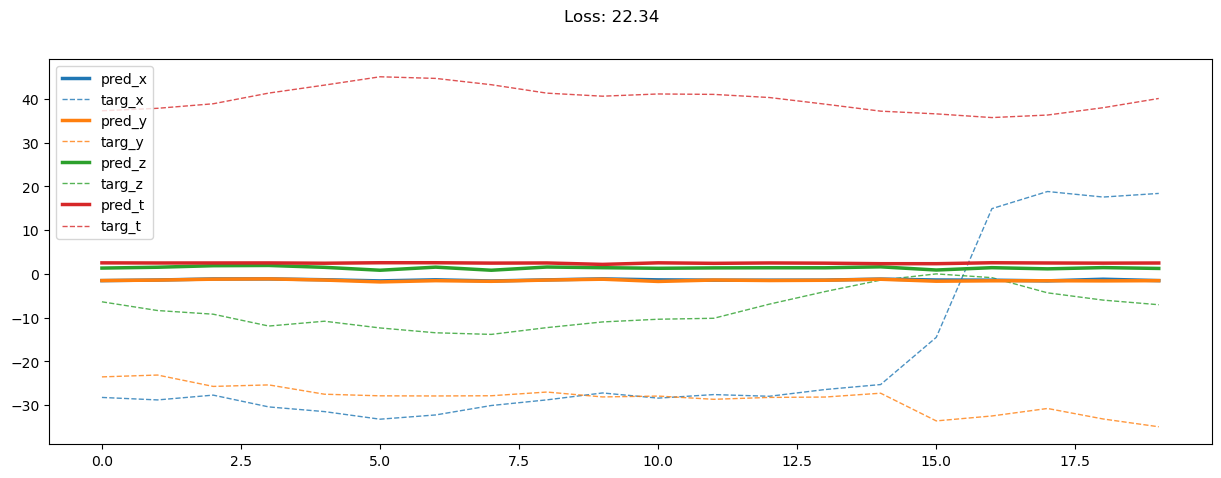

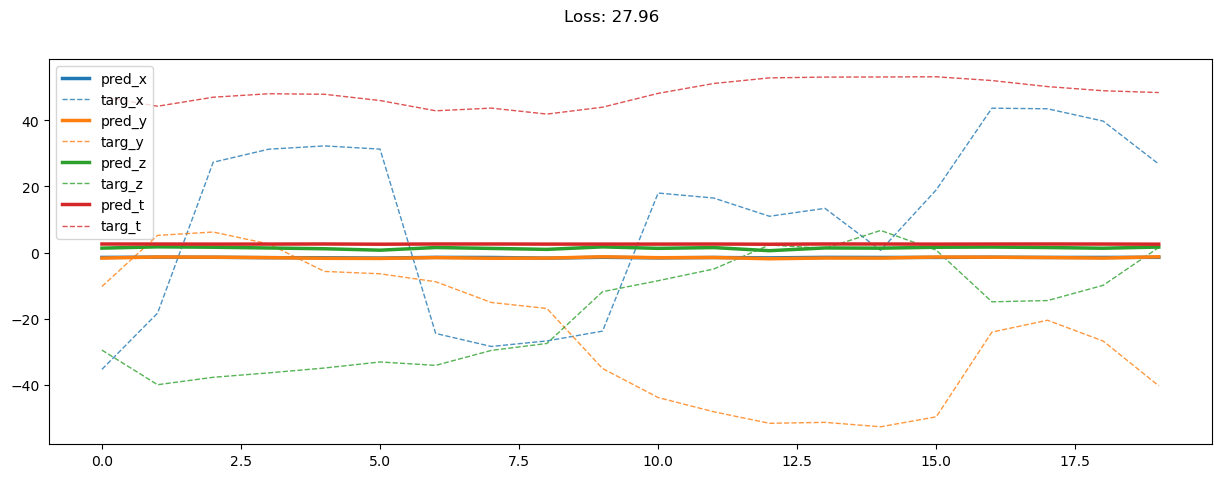

00000: train loss:  61.591, imu loss: 20.969, mag loss: 23.957, div loss: 21.998, slim: 39.059, tlim: 38.809
       valid loss:  98.014, imu loss: 21.833, mag loss: 26.266, div loss:  6.951, slim: 43.427, tlim: 42.810
00100: train loss:  42.001, imu loss: 18.602, mag loss: 21.575, div loss: 21.880, slim: 21.283, tlim: 21.030
       valid loss:  75.586, imu loss: 19.459, mag loss: 23.601, div loss:  6.937, slim: 26.051, tlim: 25.435
00200: train loss:  25.844, imu loss: 15.067, mag loss: 24.662, div loss: 21.610, slim:  4.769, tlim:  4.212
       valid loss:  55.485, imu loss: 15.819, mag loss: 25.679, div loss:  6.929, slim:  8.019, tlim:  6.739
00300: train loss:  24.055, imu loss: 11.344, mag loss: 23.873, div loss: 21.471, slim:  4.371, tlim:  3.775
       valid loss:  50.987, imu loss: 11.742, mag loss: 24.554, div loss:  6.937, slim:  8.687, tlim:  7.442
00400: train loss:  22.361, imu loss:  8.718, mag loss: 22.461, div loss: 20.629, slim:  4.249, tlim:  3.654
       valid loss: 

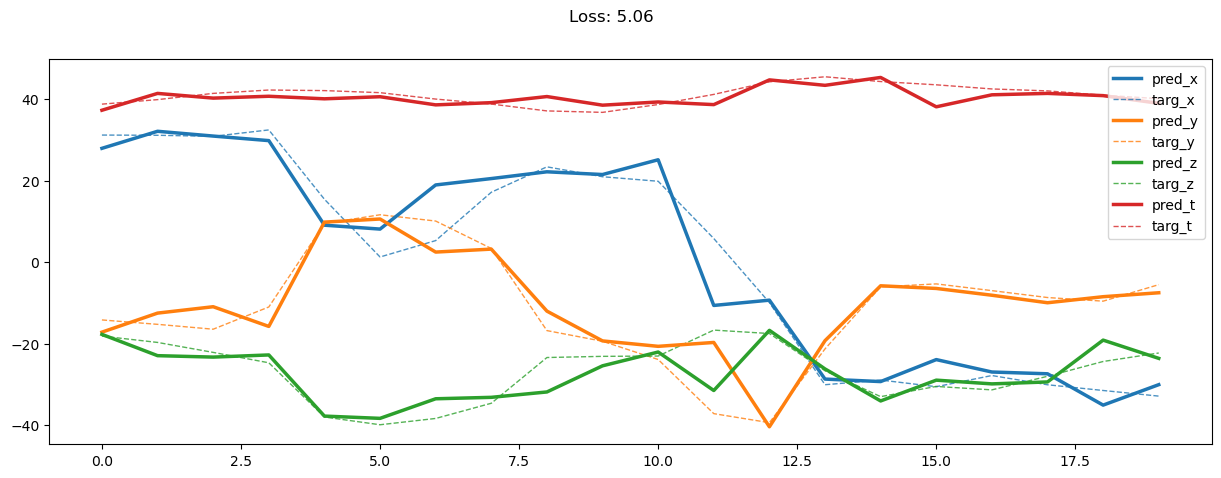

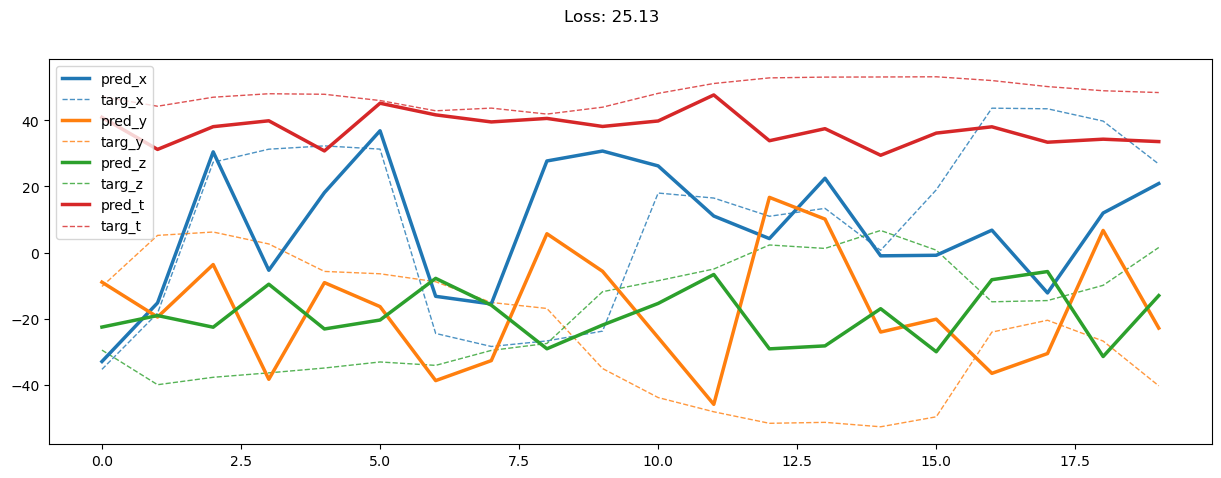

20000: train loss:   8.426, imu loss:  8.014, mag loss:  5.674, div loss:  5.180, slim:  3.854, tlim:  1.934
       valid loss:  56.195, imu loss:  8.998, mag loss: 24.948, div loss: 15.408, slim:  8.060, tlim:  6.433


In [22]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)
    
    if epoch % 100 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

In [23]:
show_result(model, train_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1280x6 and 9x16)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
num_of_axis, rotation, gt = 3, True, 'target'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)
    
    if (epoch) % 100 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
num_of_axis, rotation, gt = 3, False, 'horizontal'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
imu_layer_params = list(model.imu_layer.parameters())
encoder_params = list(model.encoder.parameters())
nn_params = list(model.nn.parameters())
initial_params = imu_layer_params + encoder_params + nn_params
optimizer = torch.optim.Adam(initial_params, lr=0.0001)

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    if epoch == 1000: optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    draw = ((epoch) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)
    
    if (epoch) % 100 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()